In [2]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import time
import psutil
import GPUtil

In [3]:
pip install psutil gputil

Note: you may need to restart the kernel to use updated packages.


In [4]:
data_dir = r'/kaggle/input/whu-rs-change-dataset'
checkpoint_dir = r'D:\Mini projact\weight_save'
os.makedirs(checkpoint_dir, exist_ok=True)

In [13]:
batch_size = 32
epochs = 5
learning_rate = 0.001
input_shape = (64, 64, 3)

In [6]:
def load_images_from_folder(folder_path, image_files):
    images = []
    for filename in image_files:
        file_path = os.path.join(folder_path, filename)
        img = Image.open(file_path).resize(input_shape[:2])  # Resize image
        img_array = np.array(img) / 255.0  # Normalize pixel values
        images.append(img_array)
    return np.array(images)


In [7]:
def load_data():
    
    with open(os.path.join(data_dir, 'list', 'train.txt'), 'r') as f:
        train_files = [line.strip() for line in f.readlines()]
    with open(os.path.join(data_dir, 'list', 'test.txt'), 'r') as f:
        test_files = [line.strip() for line in f.readlines()]
    with open(os.path.join(data_dir, 'list', 'val.txt'), 'r') as f:
        val_files = [line.strip() for line in f.readlines()]

  
    pre_images = load_images_from_folder(os.path.join(data_dir, 'A'), train_files + test_files + val_files)
    post_images = load_images_from_folder(os.path.join(data_dir, 'B'), train_files + test_files + val_files)

    
    change_maps = load_images_from_folder(os.path.join(data_dir, 'label'), train_files + test_files + val_files)
    change_maps = np.expand_dims(change_maps, axis=-1)

    return pre_images, post_images, change_maps


In [8]:
pre_images, post_images, change_maps = load_data()

In [9]:
def build_siamese_model():
    
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

   
    def conv_layers(x):
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        return x

    
    conv_base_a = conv_layers(input_a)
    conv_base_b = conv_layers(input_b)

  
    merged = Concatenate()([conv_base_a, conv_base_b])


    upsampled = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(merged)
    upsampled = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(upsampled)
    upsampled = tf.keras.layers.Conv2DTranspose(16, (3, 3), activation='relu', strides=(2, 2), padding='same')(upsampled)
    
    output = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(upsampled)  # Final output layer with target resolution

    model = Model(inputs=[input_a, input_b], outputs=output)
    return model

In [10]:
model = build_siamese_model()
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])





In [11]:
time_stamps = []
cpu_usages = []
memory_usages = []
gpu_usages = []
epoch_durations = []
images_processed = []
accuracy_over_images = []
loss_over_images = []
time_over_images = []

In [15]:
import time
import os
import psutil
import GPUtil
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint


class IoUScore(tf.keras.metrics.Metric):
    def __init__(self, name='iou_score', threshold=0.5, **kwargs):
        super(IoUScore, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
        union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) - intersection
        
        iou = tf.where(union > 0, intersection / union, 1.0)
        mean_iou = tf.reduce_mean(iou)
        
        self.total_iou.assign_add(mean_iou)
        self.count.assign_add(1.0)

    def result(self):
        return self.total_iou / self.count

    def reset_state(self):
        self.total_iou.assign(0.0)
        self.count.assign(0.0)

start_time = time.time()

process = psutil.Process(os.getpid())
cpu_usage_before = process.cpu_percent(interval=1)
memory_usage_before = process.memory_info().rss / (1024 ** 2)  # Memory in MB

gpus = GPUtil.getGPUs()
gpu_usage_before = gpus[0].memoryUsed if gpus else 0  # GPU memory in MB

def monitor_metrics():
    """Track CPU, memory, and GPU usage."""
    time_stamps.append(time.time())
    cpu_usages.append(process.cpu_percent(interval=None))
    memory_usages.append(process.memory_info().rss / (1024 ** 2))  # Convert bytes to MB
    if gpus:
        gpu_usages.append(gpus[0].memoryUsed)

class MetricsTracker(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        
    def on_batch_end(self, batch, logs=None):
        # Track metrics for each batch
        images_processed.append((batch + 1) * batch_size)  # Total images processed
        accuracy_over_images.append(logs.get('accuracy', 0))
        loss_over_images.append(logs.get('loss', 0))
        time_over_images.append(time.time() - self.epoch_start_time)
        
    def on_epoch_end(self, epoch, logs=None):
        monitor_metrics()
        epoch_durations.append(time.time() - self.epoch_start_time)
        print(f"\nEpoch {epoch + 1} - IoU Score: {logs.get('iou_score', 0):.4f}")


model.compile(
    optimizer=model.optimizer,
    loss=model.loss,
    metrics=['accuracy',IoUScore(name='iou_score') ]
)


checkpoint_path = os.path.join(checkpoint_dir, 'model.{epoch:02d}-{val_loss:.2f}-{val_iou_score:.4f}.keras')
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_iou_score',
    mode='max',
    save_best_only=True
)



history = model.fit(
    [pre_images, post_images], change_maps,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[checkpoint_callback, MetricsTracker()]
)

end_time = time.time()
duration = end_time - start_time


cpu_usage_after = process.cpu_percent(interval=1)
memory_usage_after = process.memory_info().rss / (1024 ** 2)  # Memory in MB
gpu_usage_after = gpus[0].memoryUsed if gpus else 0  # GPU memory in MB


print(f"\nTraining Results:")
print(f"Total training time: {duration:.2f} seconds")
print(f"CPU usage before training: {cpu_usage_before}%")
print(f"CPU usage after training: {cpu_usage_after}%")
print(f"Memory usage before training: {memory_usage_before:.2f} MB")
print(f"Memory usage after training: {memory_usage_after:.2f} MB")
if gpus:
    print(f"GPU memory usage before training: {gpu_usage_before:.2f} MB")
    print(f"GPU memory usage after training: {gpu_usage_after:.2f} MB")


final_iou = history.history['val_iou_score'][-1]
print(f"Final Validation IoU Score: {final_iou:.4f}")


model.save('siamese_change_detection_model.keras')

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9469 - iou_score: 0.6028 - loss: 0.3107
Epoch 1 - IoU Score: 0.7102
191/191 ━━━━━━━━━━━━━━━━━━━━ 62s 312ms/step - accuracy: 0.9469 - iou_score: 0.6034 - loss: 0.3102 - val_accuracy: 0.9508 - val_iou_score: 0.7445 - val_loss: 0.1574
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9520 - iou_score: 0.7449 - loss: 0.1443
Epoch 2 - IoU Score: 0.7488
191/191 ━━━━━━━━━━━━━━━━━━━━ 58s 302ms/step - accuracy: 0.9520 - iou_score: 0.7449 - loss: 0.1443 - val_accuracy: 0.9508 - val_iou_score: 0.7445 - val_loss: 0.1348
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9550 - iou_score: 0.7456 - loss: 0.1325
Epoch 3 - IoU Score: 0.7463
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 299ms/step - accuracy: 0.9550 - iou_score: 0.7456 - loss: 0.1324 - val_accuracy: 0.9512 - val_iou_score: 0.7459 - val_loss: 0.1302
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9566 - iou_score: 0.7376 - loss: 0.1

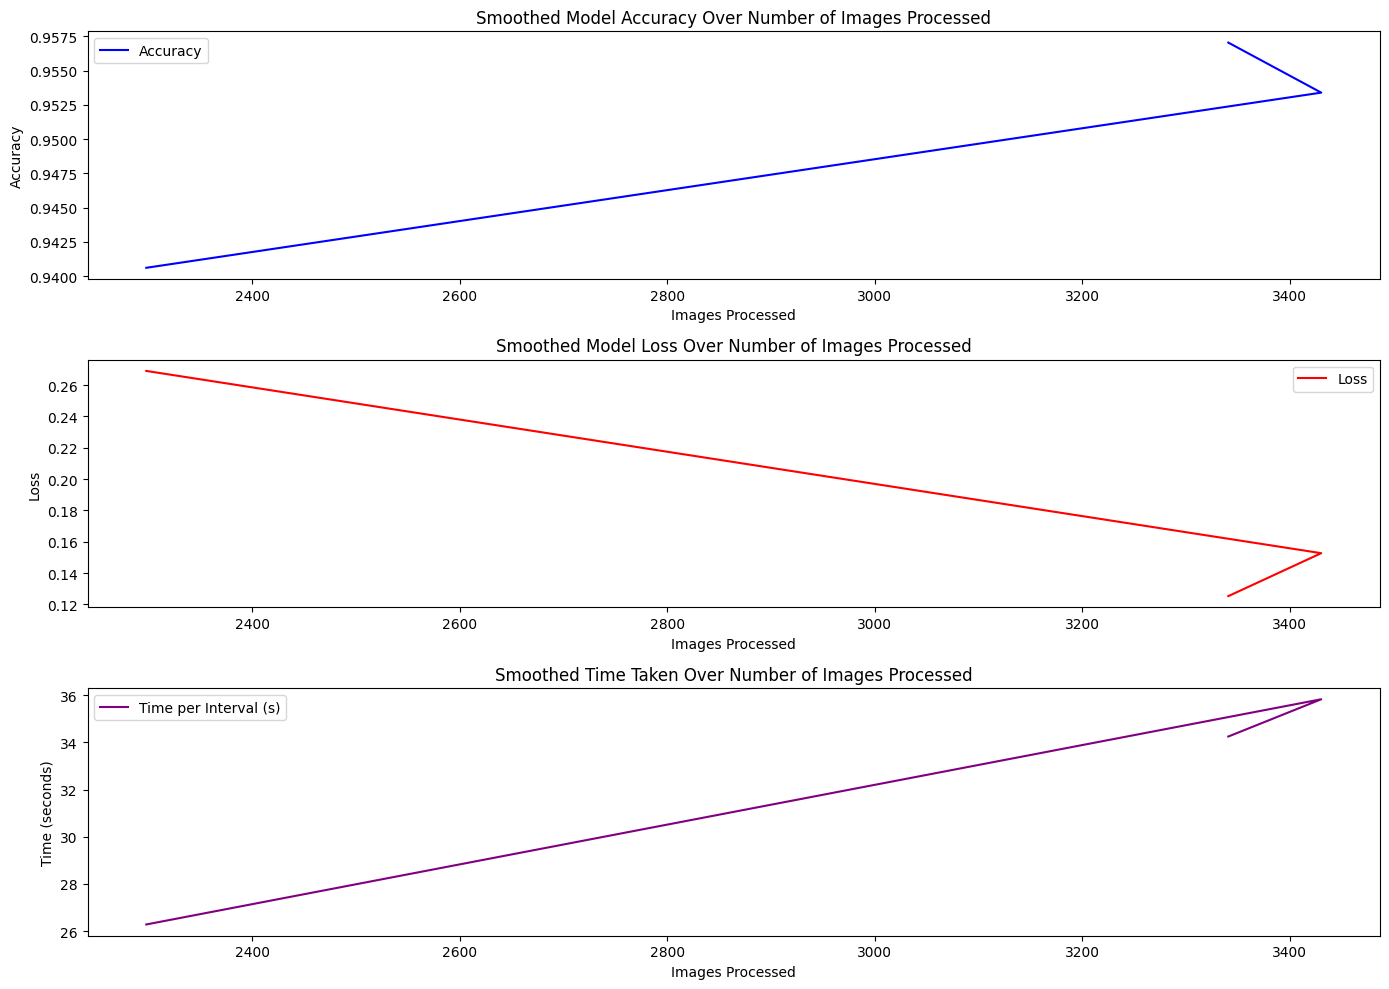

In [16]:
import numpy as np
import matplotlib.pyplot as plt


interval = 150
images_processed_interval = images_processed[::interval]
accuracy_over_images_interval = accuracy_over_images[::interval]
loss_over_images_interval = loss_over_images[::interval]
time_over_images_interval = time_over_images[::interval]


def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

smoothed_accuracy = moving_average(accuracy_over_images_interval, window_size=5)
smoothed_loss = moving_average(loss_over_images_interval, window_size=5)
smoothed_time = moving_average(time_over_images_interval, window_size=5)
smoothed_images = moving_average(images_processed_interval, window_size=5)


plt.figure(figsize=(14, 10))


plt.subplot(3, 1, 1)
plt.plot(smoothed_images, smoothed_accuracy, label='Accuracy', color='blue')
plt.xlabel('Images Processed')
plt.ylabel('Accuracy')
plt.title('Smoothed Model Accuracy Over Number of Images Processed')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(smoothed_images, smoothed_loss, label='Loss', color='red')
plt.xlabel('Images Processed')
plt.ylabel('Loss')
plt.title('Smoothed Model Loss Over Number of Images Processed')
plt.legend()


plt.subplot(3, 1, 3)
plt.plot(smoothed_images, smoothed_time, label='Time per Interval (s)', color='purple')
plt.xlabel('Images Processed')
plt.ylabel('Time (seconds)')
plt.title('Smoothed Time Taken Over Number of Images Processed')
plt.legend()

plt.tight_layout()
plt.show()


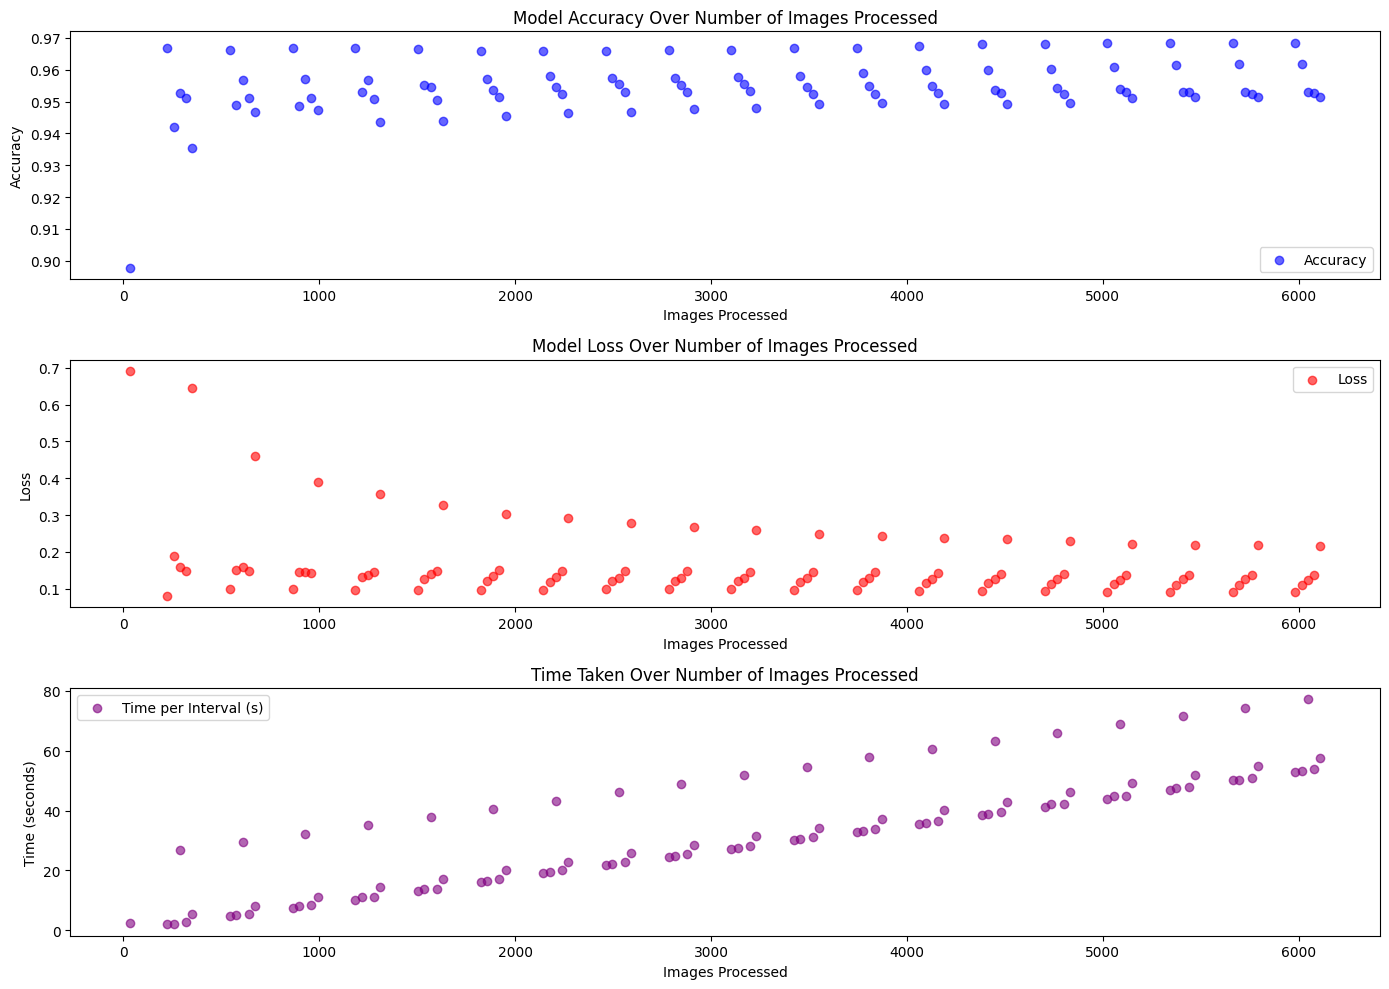

In [17]:
import numpy as np
import matplotlib.pyplot as plt


interval = 10
images_processed_interval = images_processed[::interval]
accuracy_over_images_interval = accuracy_over_images[::interval]
loss_over_images_interval = loss_over_images[::interval]
time_over_images_interval = time_over_images[::interval]


plt.figure(figsize=(14, 10))


plt.subplot(3, 1, 1)
plt.scatter(images_processed_interval, accuracy_over_images_interval, label='Accuracy', color='blue', alpha=0.6)
plt.xlabel('Images Processed')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Number of Images Processed')
plt.legend()


plt.subplot(3, 1, 2)
plt.scatter(images_processed_interval, loss_over_images_interval, label='Loss', color='red', alpha=0.6)
plt.xlabel('Images Processed')
plt.ylabel('Loss')
plt.title('Model Loss Over Number of Images Processed')
plt.legend()


plt.subplot(3, 1, 3)
plt.scatter(images_processed_interval, time_over_images_interval, label='Time per Interval (s)', color='purple', alpha=0.6)
plt.xlabel('Images Processed')
plt.ylabel('Time (seconds)')
plt.title('Time Taken Over Number of Images Processed')
plt.legend()

plt.tight_layout()
plt.show()


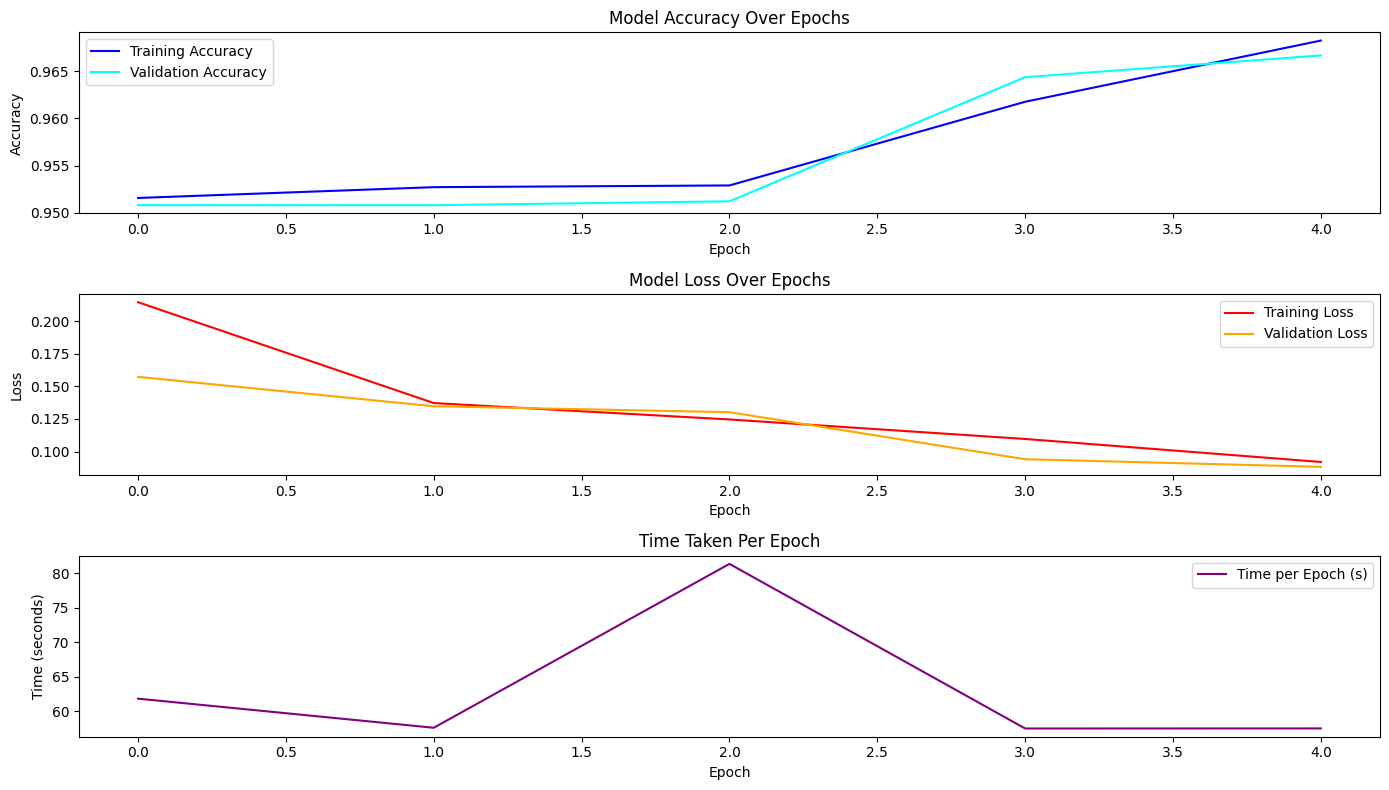

Total training time: 318.45 seconds


In [18]:
plt.figure(figsize=(14, 8))


plt.subplot(3, 1, 1)
plt.plot(history.epoch, history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy', color='cyan')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(history.epoch, history.history['loss'], label='Training Loss', color='red')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()


plt.subplot(3, 1, 3)
plt.plot(range(len(epoch_durations)), epoch_durations, label='Time per Epoch (s)', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Time Taken Per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


print(f"Total training time: {duration:.2f} seconds")